# 캐글코리아 2nd ML Competition: House Price Prediction

- [캐글 페이지](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

## 목차

1. 데이터 탐색 및 전처리
2. 모델 설계 및 학습
3. 평가 및 회고

In [1]:
import os
from os.path import join

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats as stats

import missingno as msno 

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV

import lightgbm as lgb  
import xgboost as xgb 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # 폰트 주변이 흐릿하게 보이는 것을 방지

<br>

## 1. 데이터 탐색 및 전처리

### 1-1. 데이터 불러오기

- [데이터셋 다운로드](https://d3s0tskafalll9.cloudfront.net/media/documents/kaggle-kakr-housing-data.zip)

In [2]:
data_dir = os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E6_kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

# 첫 번째 column을 index로 지정하여 데이터 불러오기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

In [3]:
print("train 데이터 크기:", data.shape)
print("test 데이터 크기:", sub.shape)

train 데이터 크기: (15035, 21)
test 데이터 크기: (6468, 20)


In [4]:
data.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [5]:
sub.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

각 변수들이 나타내는 의미는 다음과 같다.

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

<br>

- 본격적인 데이터 전처리를 시작하기 앞서 train 데이터에서 label인 price를 변수에 따로 저장한다.
- 전처리를 위해 train, test 데이터셋을 합친다.

In [6]:
# train 데이터셋에서 label 제거
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
# sub_id에 id column 저장해두기
sub_id = sub['id']

In [8]:
# 전처리를 위해 train, test 데이터셋 합치기
# 합치기 전 train 데이터셋의 길이를 저장해둔다
train_len = len(data)

data = pd.concat((data, sub), axis=0)

# id column drop
data.drop('id', axis=1, inplace=True)

<br>

- date column은 연도와 월만 남긴다.

In [9]:
# date column에서 연도와 월만 남기기
data['date'] = data['date'].apply(lambda x: x[:6]).astype(int)

data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410         3       1.00         1180      5650     1.0           0   
1  201502         2       1.00          770     10000     1.0           0   
2  201502         3       2.00         1680      8080     1.0           0   
3  201406         3       2.25         1715      6819     2.0           0   
4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

<br>

### 1-2. 결측치 확인 및 처리

- msno.matrix를 통해 시각화하는 방법과 각 column의 결측치 개수를 확인하는 방법을 이용

<AxesSubplot:>

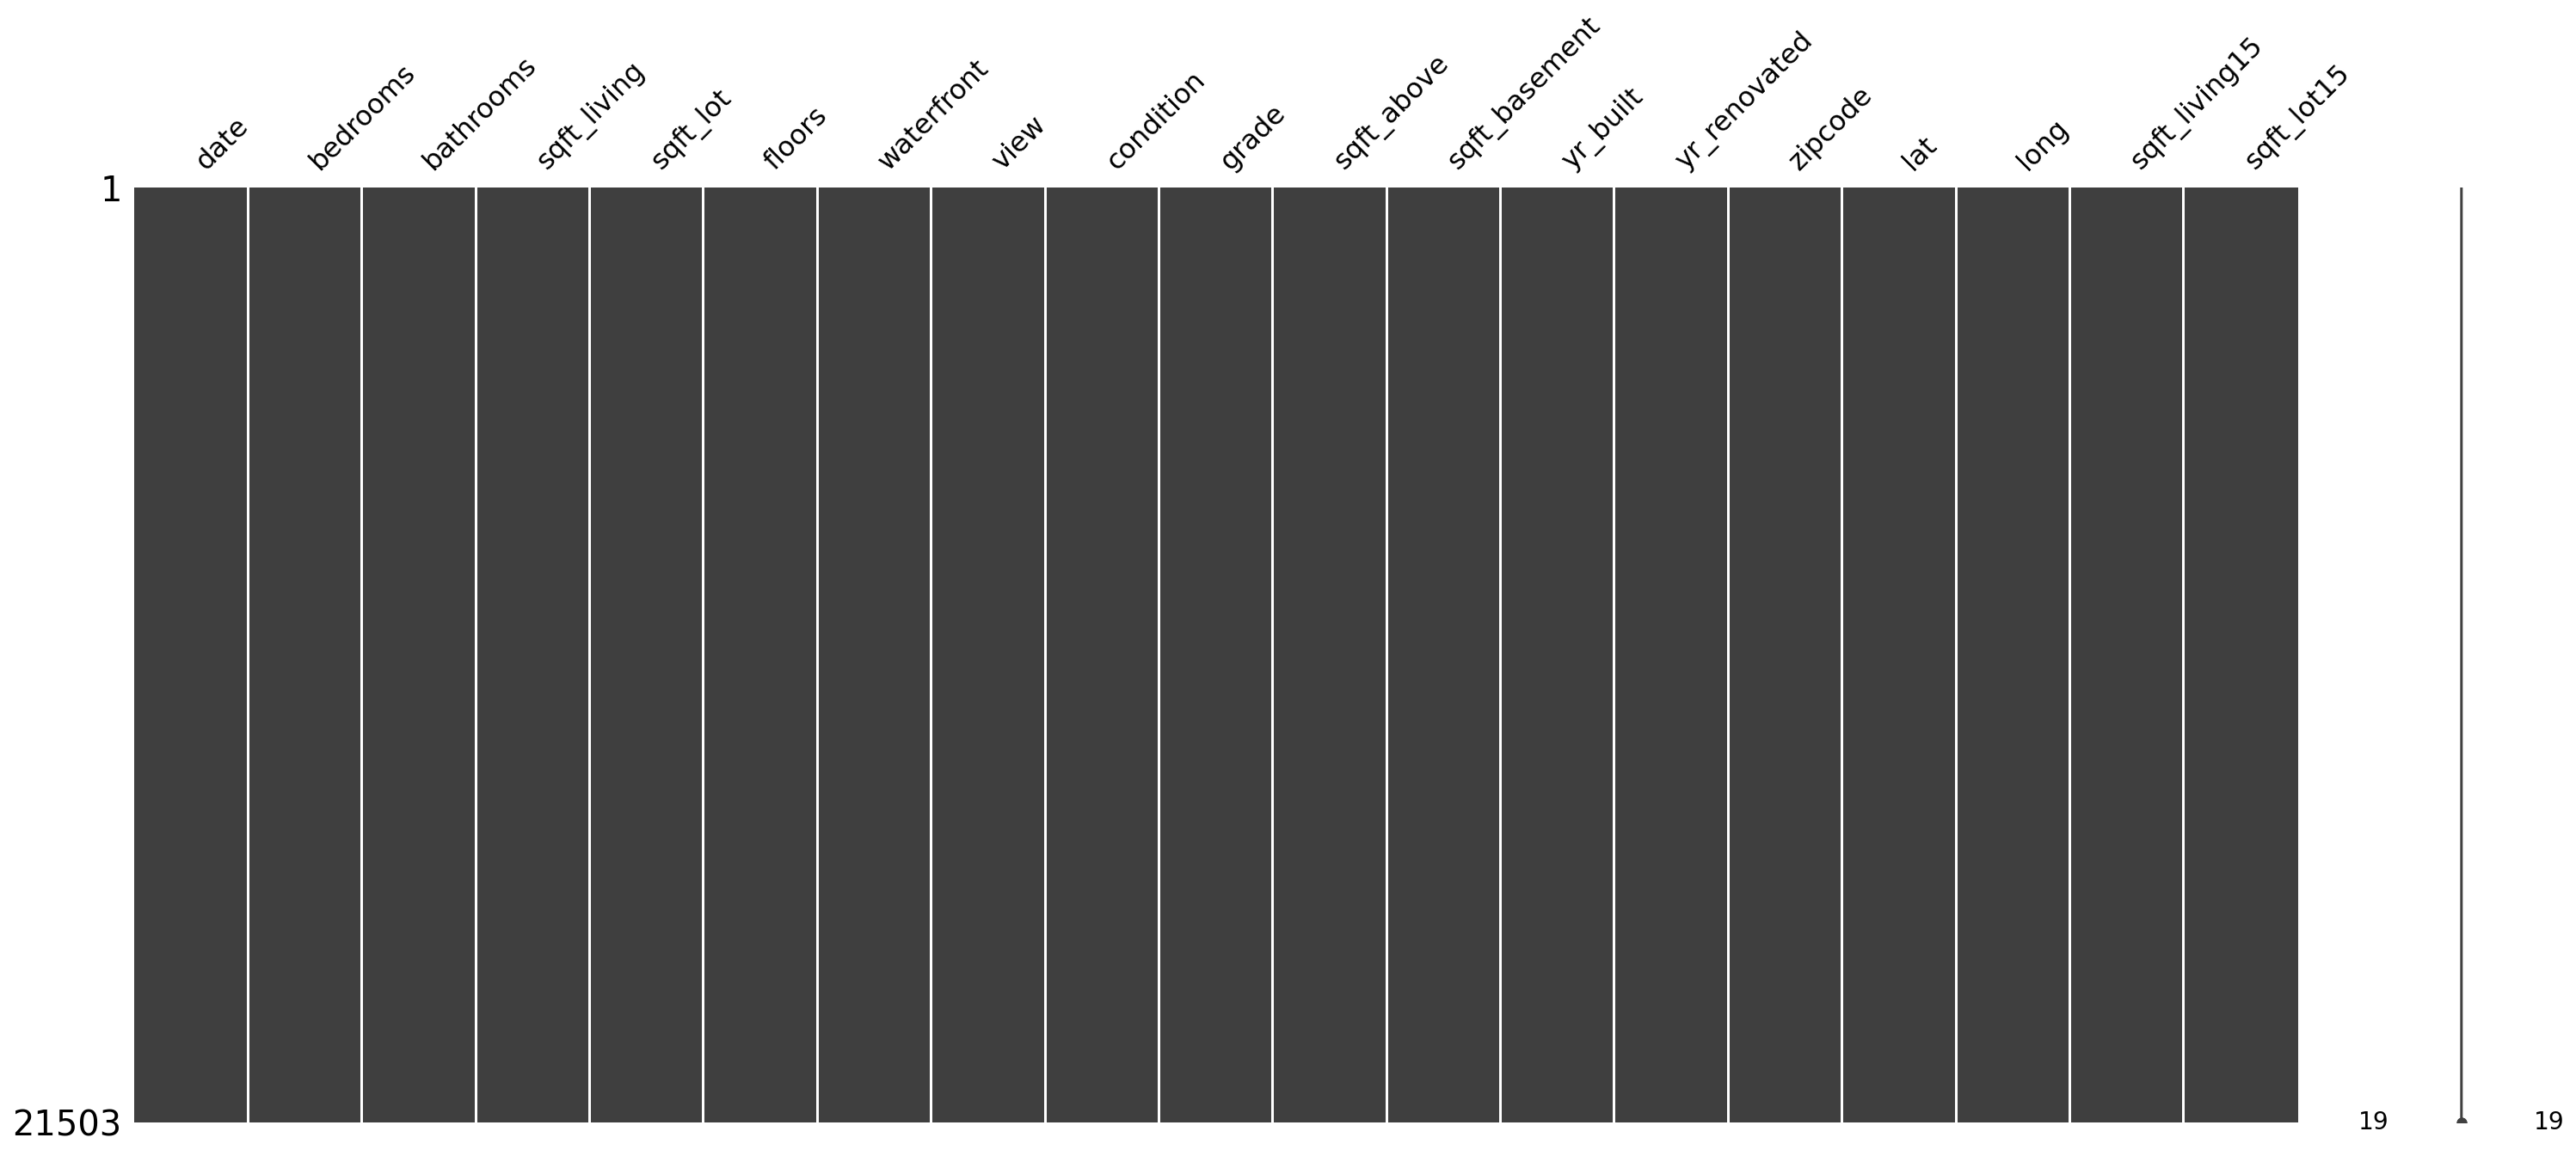

In [10]:
# 결측치 시각화해서 확인하기
msno.matrix(data)

In [11]:
# 결측치 개수 확인하기
for c in data.columns:
    print(f"{c}: {len(data.loc[pd.isnull(data[c]), c].values)}")

date: 0
bedrooms: 0
bathrooms: 0
sqft_living: 0
sqft_lot: 0
floors: 0
waterfront: 0
view: 0
condition: 0
grade: 0
sqft_above: 0
sqft_basement: 0
yr_built: 0
yr_renovated: 0
zipcode: 0
lat: 0
long: 0
sqft_living15: 0
sqft_lot15: 0


### 1-3. 데이터 분포 확인

- 각 feature들의 분포를 sns.kdeplot을 통해 시각화하여 살펴본다.
- 연속적인 값의 featrue들 중에 한쪽으로 치우침이 심한 featrue를 log변환을 통해 정규화한다.

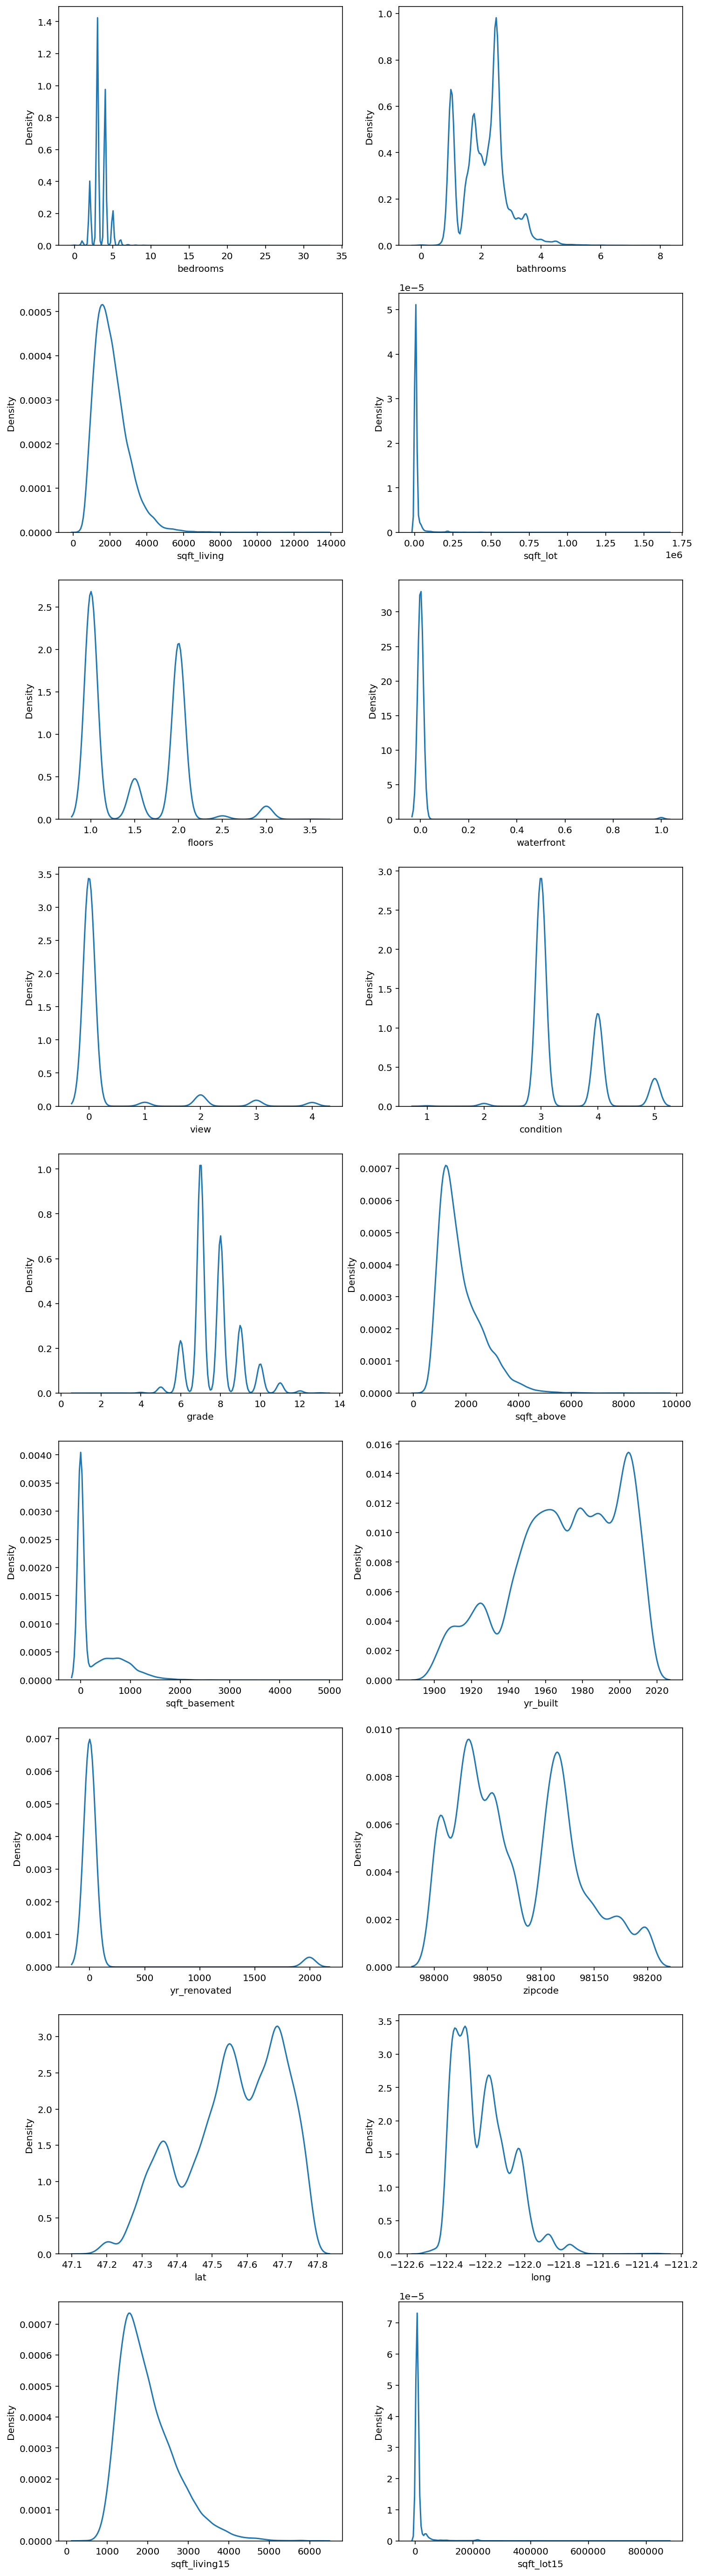

In [12]:
# data의 분포 시각화해서 확인하기
fig, ax = plt.subplots(9, 2, figsize=(12, 50))
columns = data.columns
idx = 1

for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[idx]], ax=ax[row][col])
        idx += 1
        
        if idx == 19:
            break

In [13]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

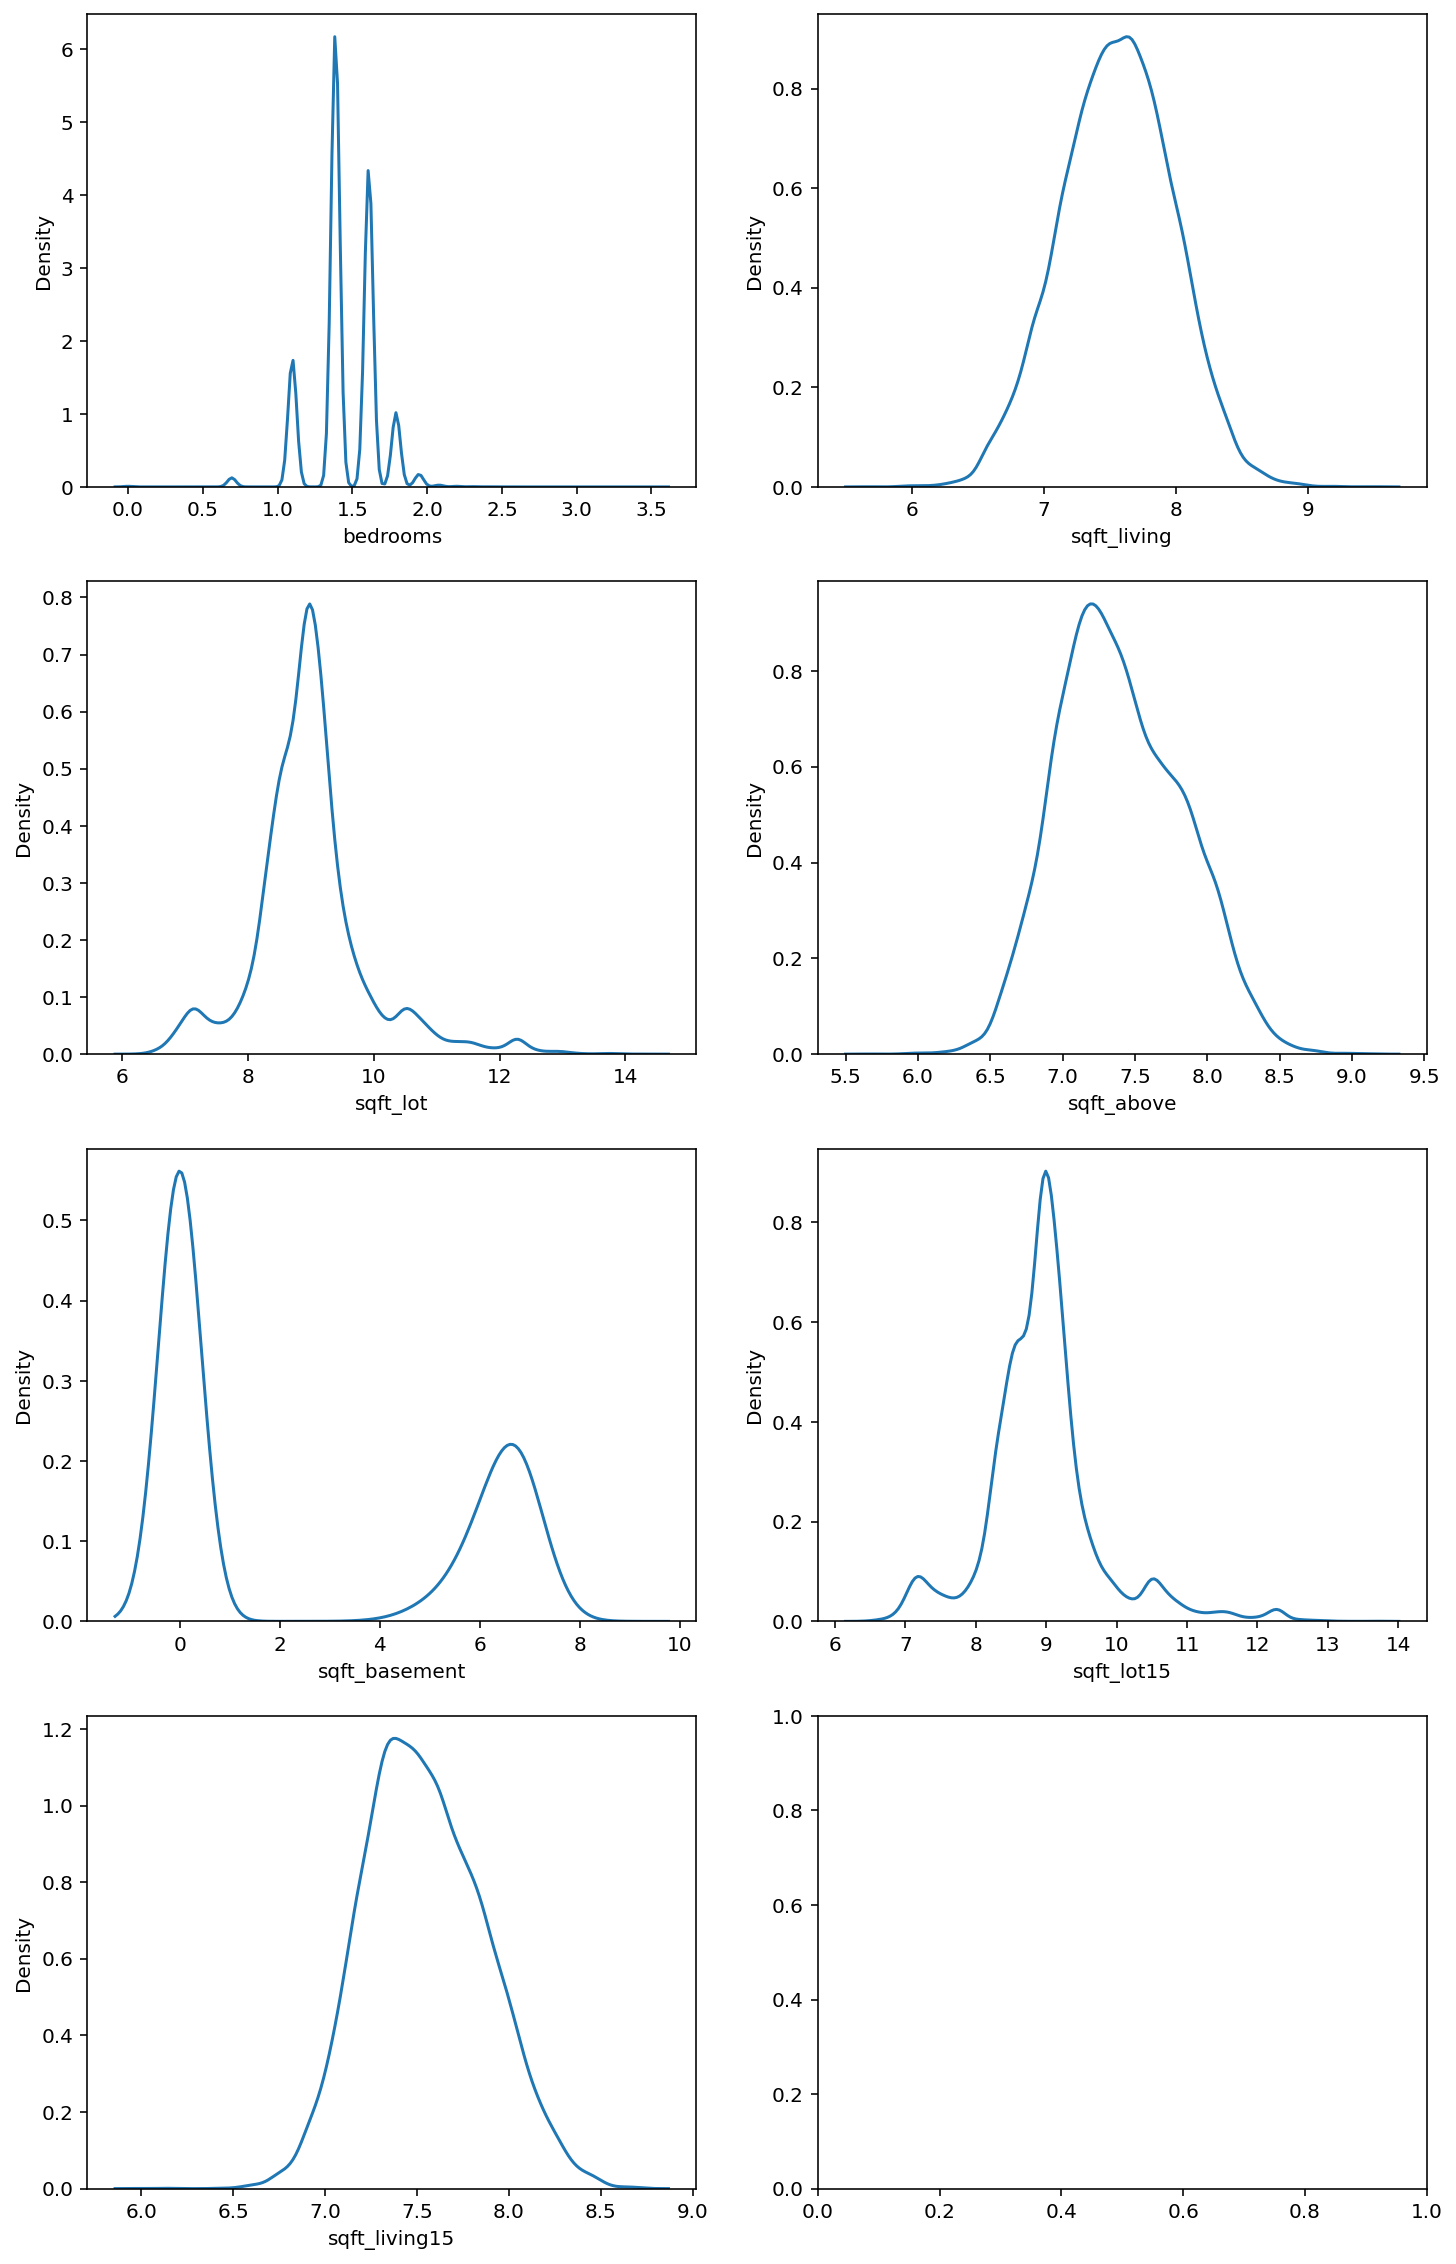

In [14]:
# 정규화 결과 확인하기
fig, ax = plt.subplots(4, 2, figsize=(12, 20))

idx = 0

for row in range(4):
    for col in range(2):
        if idx == 7:
            break
            
        sns.kdeplot(data[skew_columns[idx]], ax=ax[row][col])
        idx += 1

In [15]:
# label data 살펴보기
print(y)

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64


<AxesSubplot:xlabel='price', ylabel='Density'>

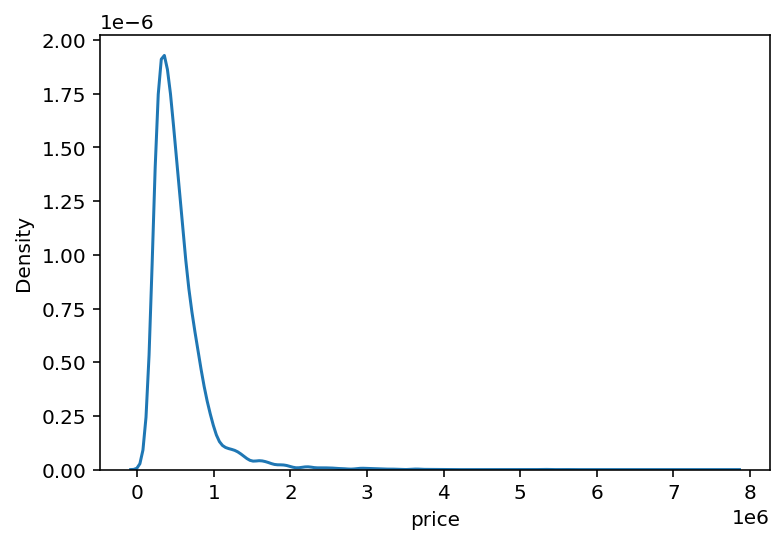

In [16]:
# 시각화해보기
sns.kdeplot(y)

In [17]:
# log 변환을 통해 치우친 형태를 정규 분포 형태로 바꾸기
y = np.log1p(y)

print(y)

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64


<AxesSubplot:xlabel='price', ylabel='Density'>

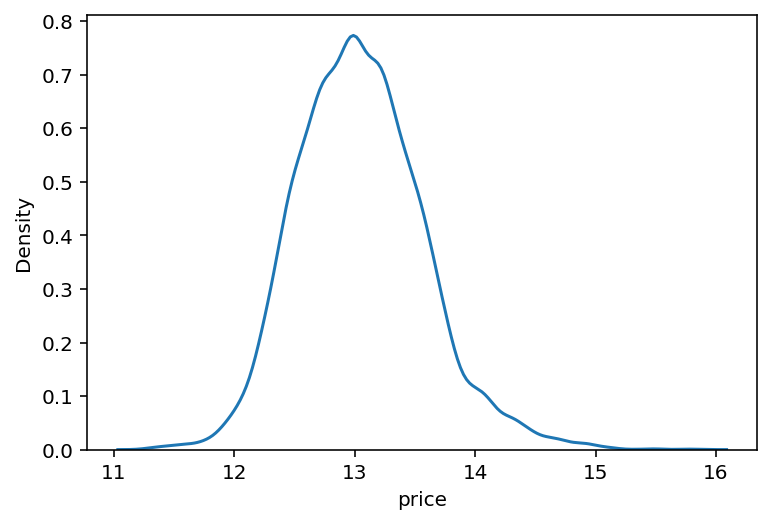

In [18]:
# 시각화해서 확인해보기
sns.kdeplot(y)

<br>

### 1-4. feature 상관 분석

- 상관 분석을 위해 data에 label 데이터인 price column을 일시적으로 추가해준다.
- 각 feature간 spearman 상관 계수를 살펴본다.
- 위 상관 계수를 p-value로 검증한다.
- 각 feature과 price의 관계를 scatter plot과 regplot을 그려서 살펴본다.

In [19]:
test_data = data.iloc[train_len:, :]
train_data = data.iloc[:train_len, :]

In [20]:
train_data['price'] = y

train_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410  1.386294       1.00     7.074117  8.639588     1.0           0   
1  201502  1.098612       1.00     6.647688  9.210440     1.0           0   
2  201502  1.386294       2.00     7.427144  8.997271     1.0           0   
3  201406  1.386294       2.25     7.447751  8.827615     2.0           0   
4  201501  1.386294       1.50     6.966967  9.181118     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7    7.074117            0.0      1955             0   
1     0          3      6    6.647688            0.0      1933             0   
2     0          3      8    7.427144            0.0      1987             0   
3     0          3      7    7.447751            0.0      1995             0   
4     0          3      7    6.966967            0.0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15      price  
0    98178  47.5112 -122.257       7.201171    8.639588  12.309987  
1    98028  47.7379 -122.233       7.908755    8.995041  12.100718  
2    98074  47.6168 -122.045       7.496097    8.923191  13.142168  
3    98003  47.3097 -122.327       7.713785    8.827615  12.458779  
4    98198  47.4095 -122.315       7.409136    9.181118  12.583999

In [21]:
corr = train_data.corr(method='spearman').round(2)

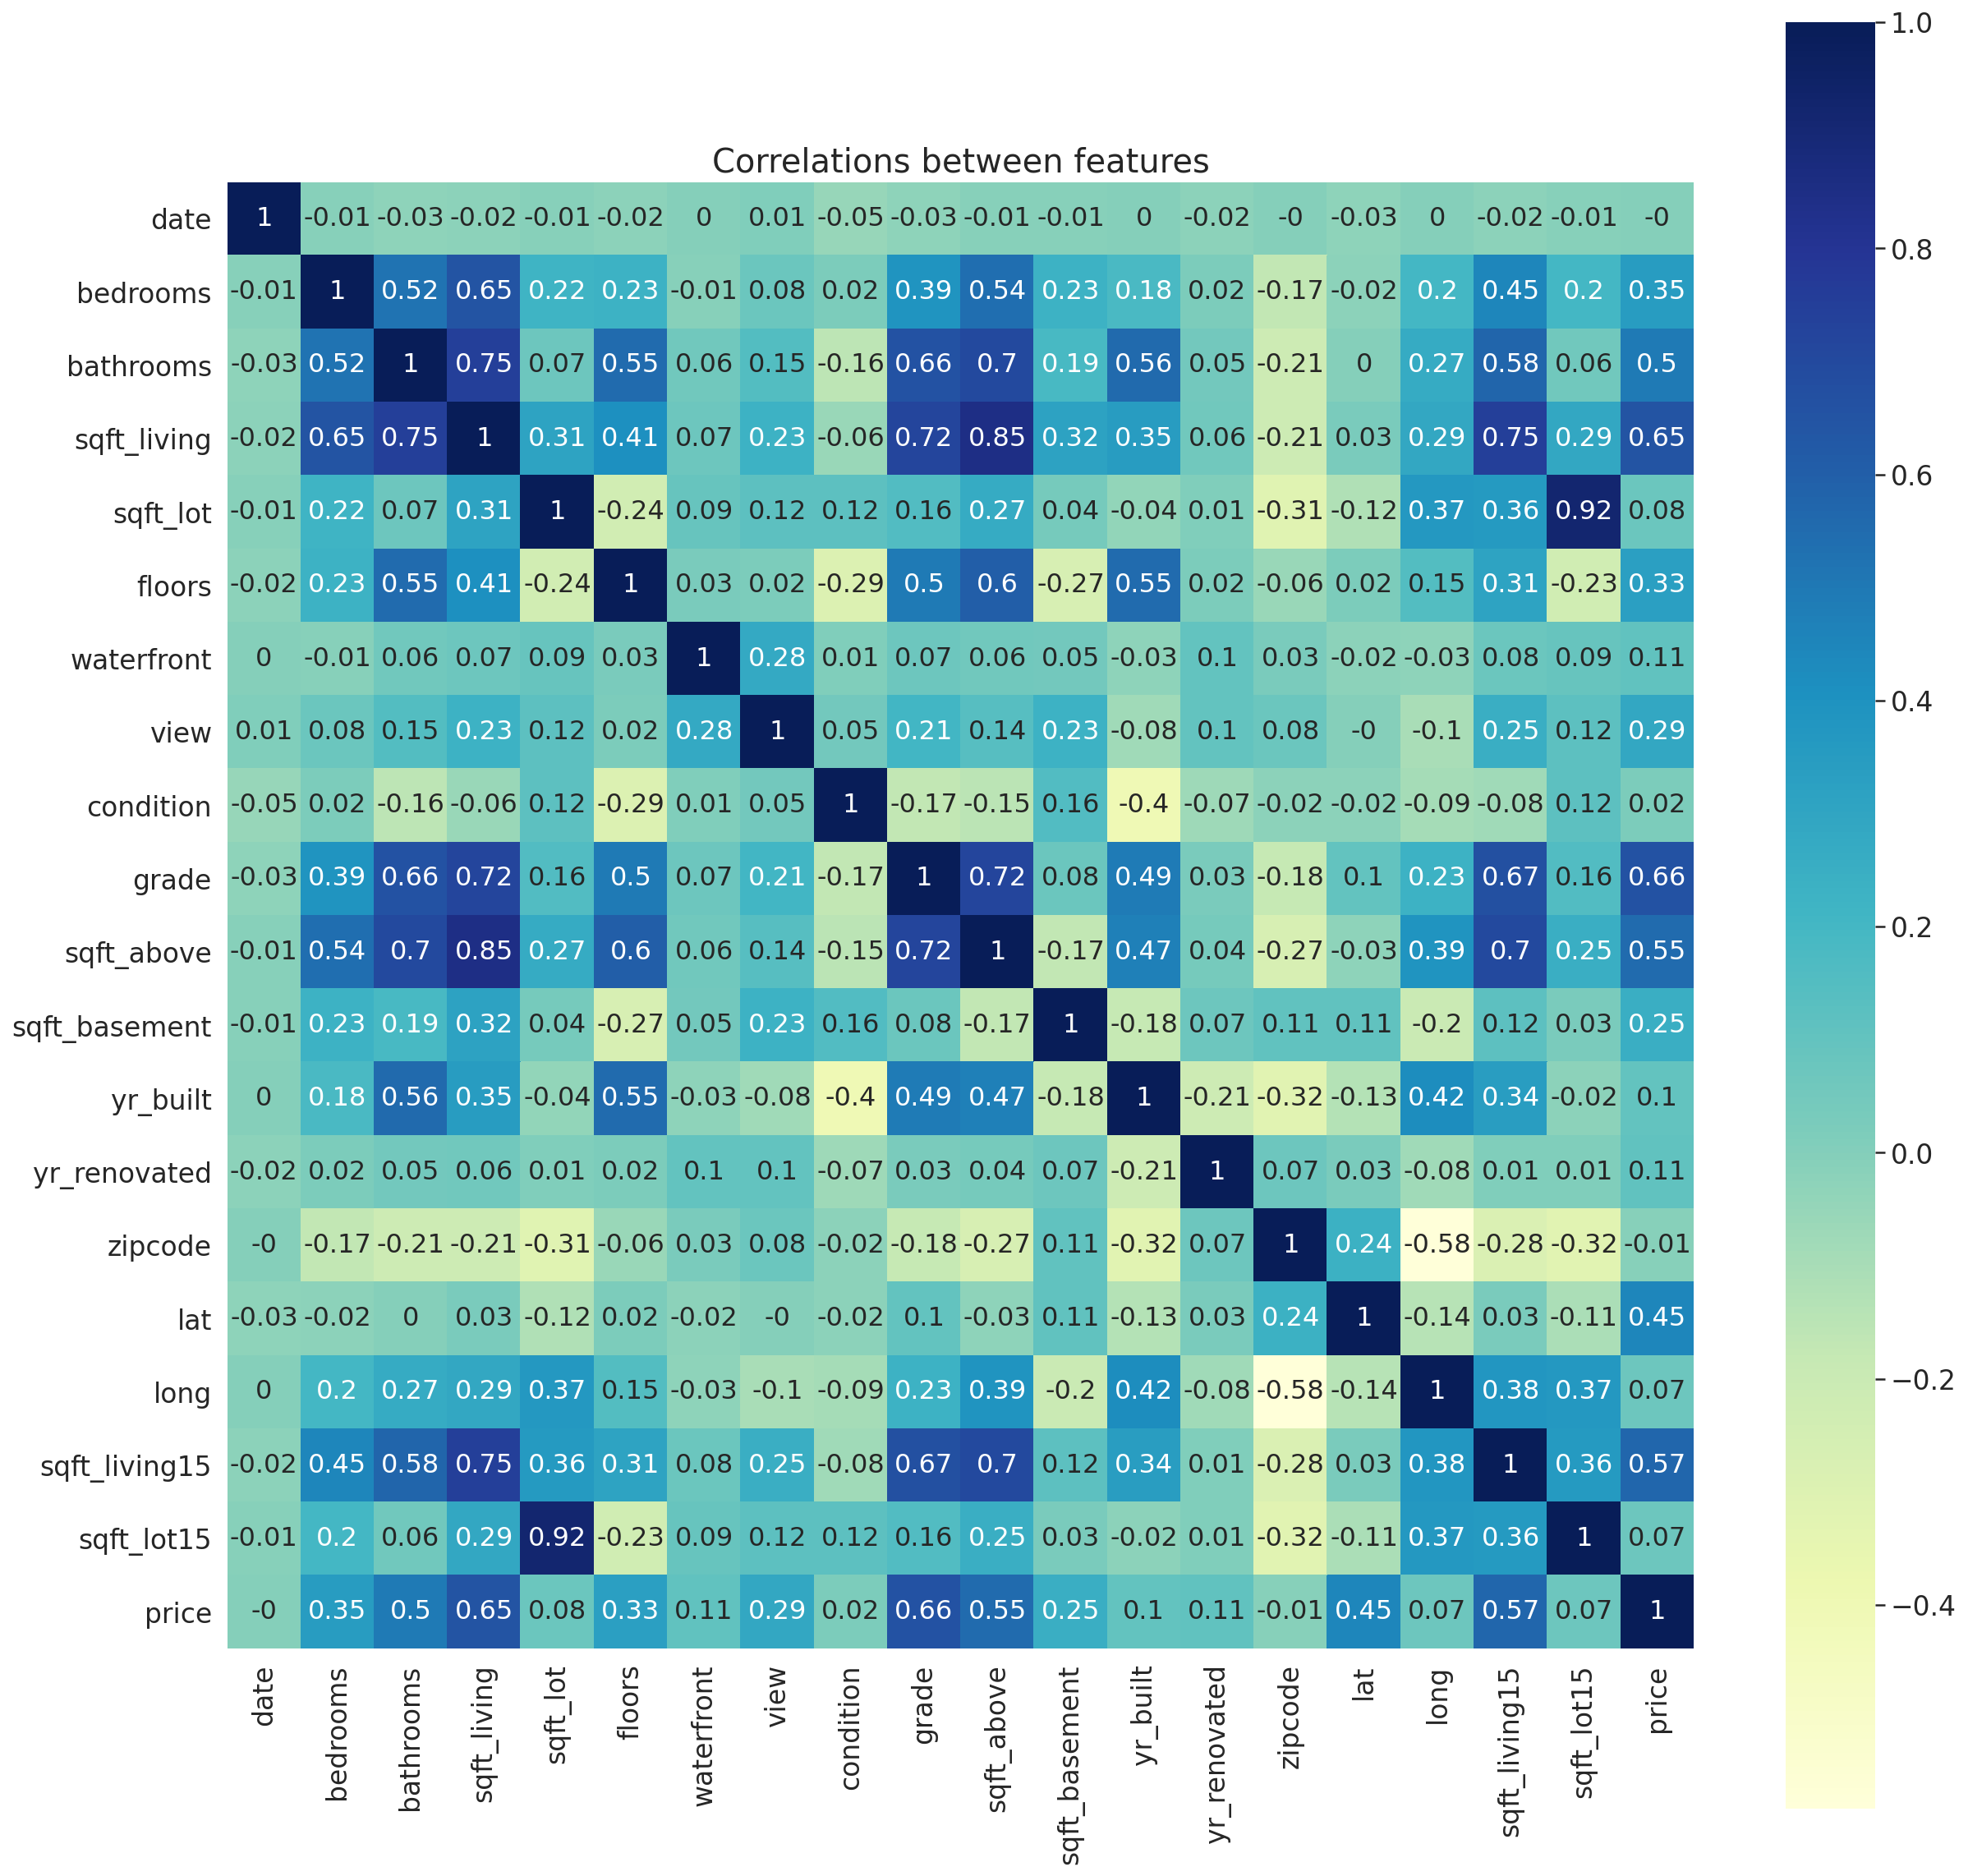

In [22]:
sns.set(font_scale=1.5)
fig = plt.subplots(figsize=(20,20))
hm = sns.heatmap(corr, annot=True, cmap='YlGnBu', square=True, annot_kws={'size': 16})

plt.title('Correlations between features', fontsize=20)
plt.show()

<br>

- price와 가장 높은 상관 관계를 갖는 feature는 순서대로 다음과 같다.
    - 1) grade: 0.66
    - 2) sqft_living: 0.65
    - 3) sqft_living15: 0.57
    - 4) sqft_above: 0.55
    - 5) bathrooms: 0.5
    - 6) lat: 0.45
    - 7) bedrooms: 0.35
    - 8) floors: 0.33


- p-value를 통해 상관 계수를 검정한다.
    - 0.05보다 작은 변수들은 귀무가설을 기각하고 대립가설을 채택한다. 즉, 상관 관계가 있다고 본다.
    - 0.2559로 나타난 zipcode는 상관 관계가 없다고 본다.

In [23]:
# date column을 제외한 나머지 column을 살펴본다
tmp_data = train_data.drop('date', axis=1, inplace=False)

tmp_data.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0  1.386294       1.00     7.074117  8.639588     1.0           0     0   
1  1.098612       1.00     6.647688  9.210440     1.0           0     0   
2  1.386294       2.00     7.427144  8.997271     1.0           0     0   
3  1.386294       2.25     7.447751  8.827615     2.0           0     0   
4  1.386294       1.50     6.966967  9.181118     1.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7    7.074117            0.0      1955             0   
1          3      6    6.647688            0.0      1933             0   
2          3      8    7.427144            0.0      1987             0   
3          3      7    7.447751            0.0      1995             0   
4          3      7    6.966967            0.0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15      price  
0    98178  47.5112 -122.257       7.201171    8.639588  12.309987  
1    98028  47.7379 -122.233       7.908755    8.995041  12.100718  
2    98074  47.6168 -122.045       7.496097    8.923191  13.142168  
3    98003  47.3097 -122.327       7.713785    8.827615  12.458779  
4    98198  47.4095 -122.315       7.409136    9.181118  12.583999

In [24]:
for col in tmp_data.columns:
    print(col)
    print(f"p-value: {stats.spearmanr(tmp_data[col].values, tmp_data['price'].values)[1]:.4f}\n")

bedrooms
p-value: 0.0000

bathrooms
p-value: 0.0000

sqft_living
p-value: 0.0000

sqft_lot
p-value: 0.0000

floors
p-value: 0.0000

waterfront
p-value: 0.0000

view
p-value: 0.0000

condition
p-value: 0.0083

grade
p-value: 0.0000

sqft_above
p-value: 0.0000

sqft_basement
p-value: 0.0000

yr_built
p-value: 0.0000

yr_renovated
p-value: 0.0000

zipcode
p-value: 0.2559

lat
p-value: 0.0000

long
p-value: 0.0000

sqft_living15
p-value: 0.0000

sqft_lot15
p-value: 0.0000

price
p-value: 0.0000



<br>

- scatter plot을 그려 각 feature와 price 사이 관계를 알아본다.

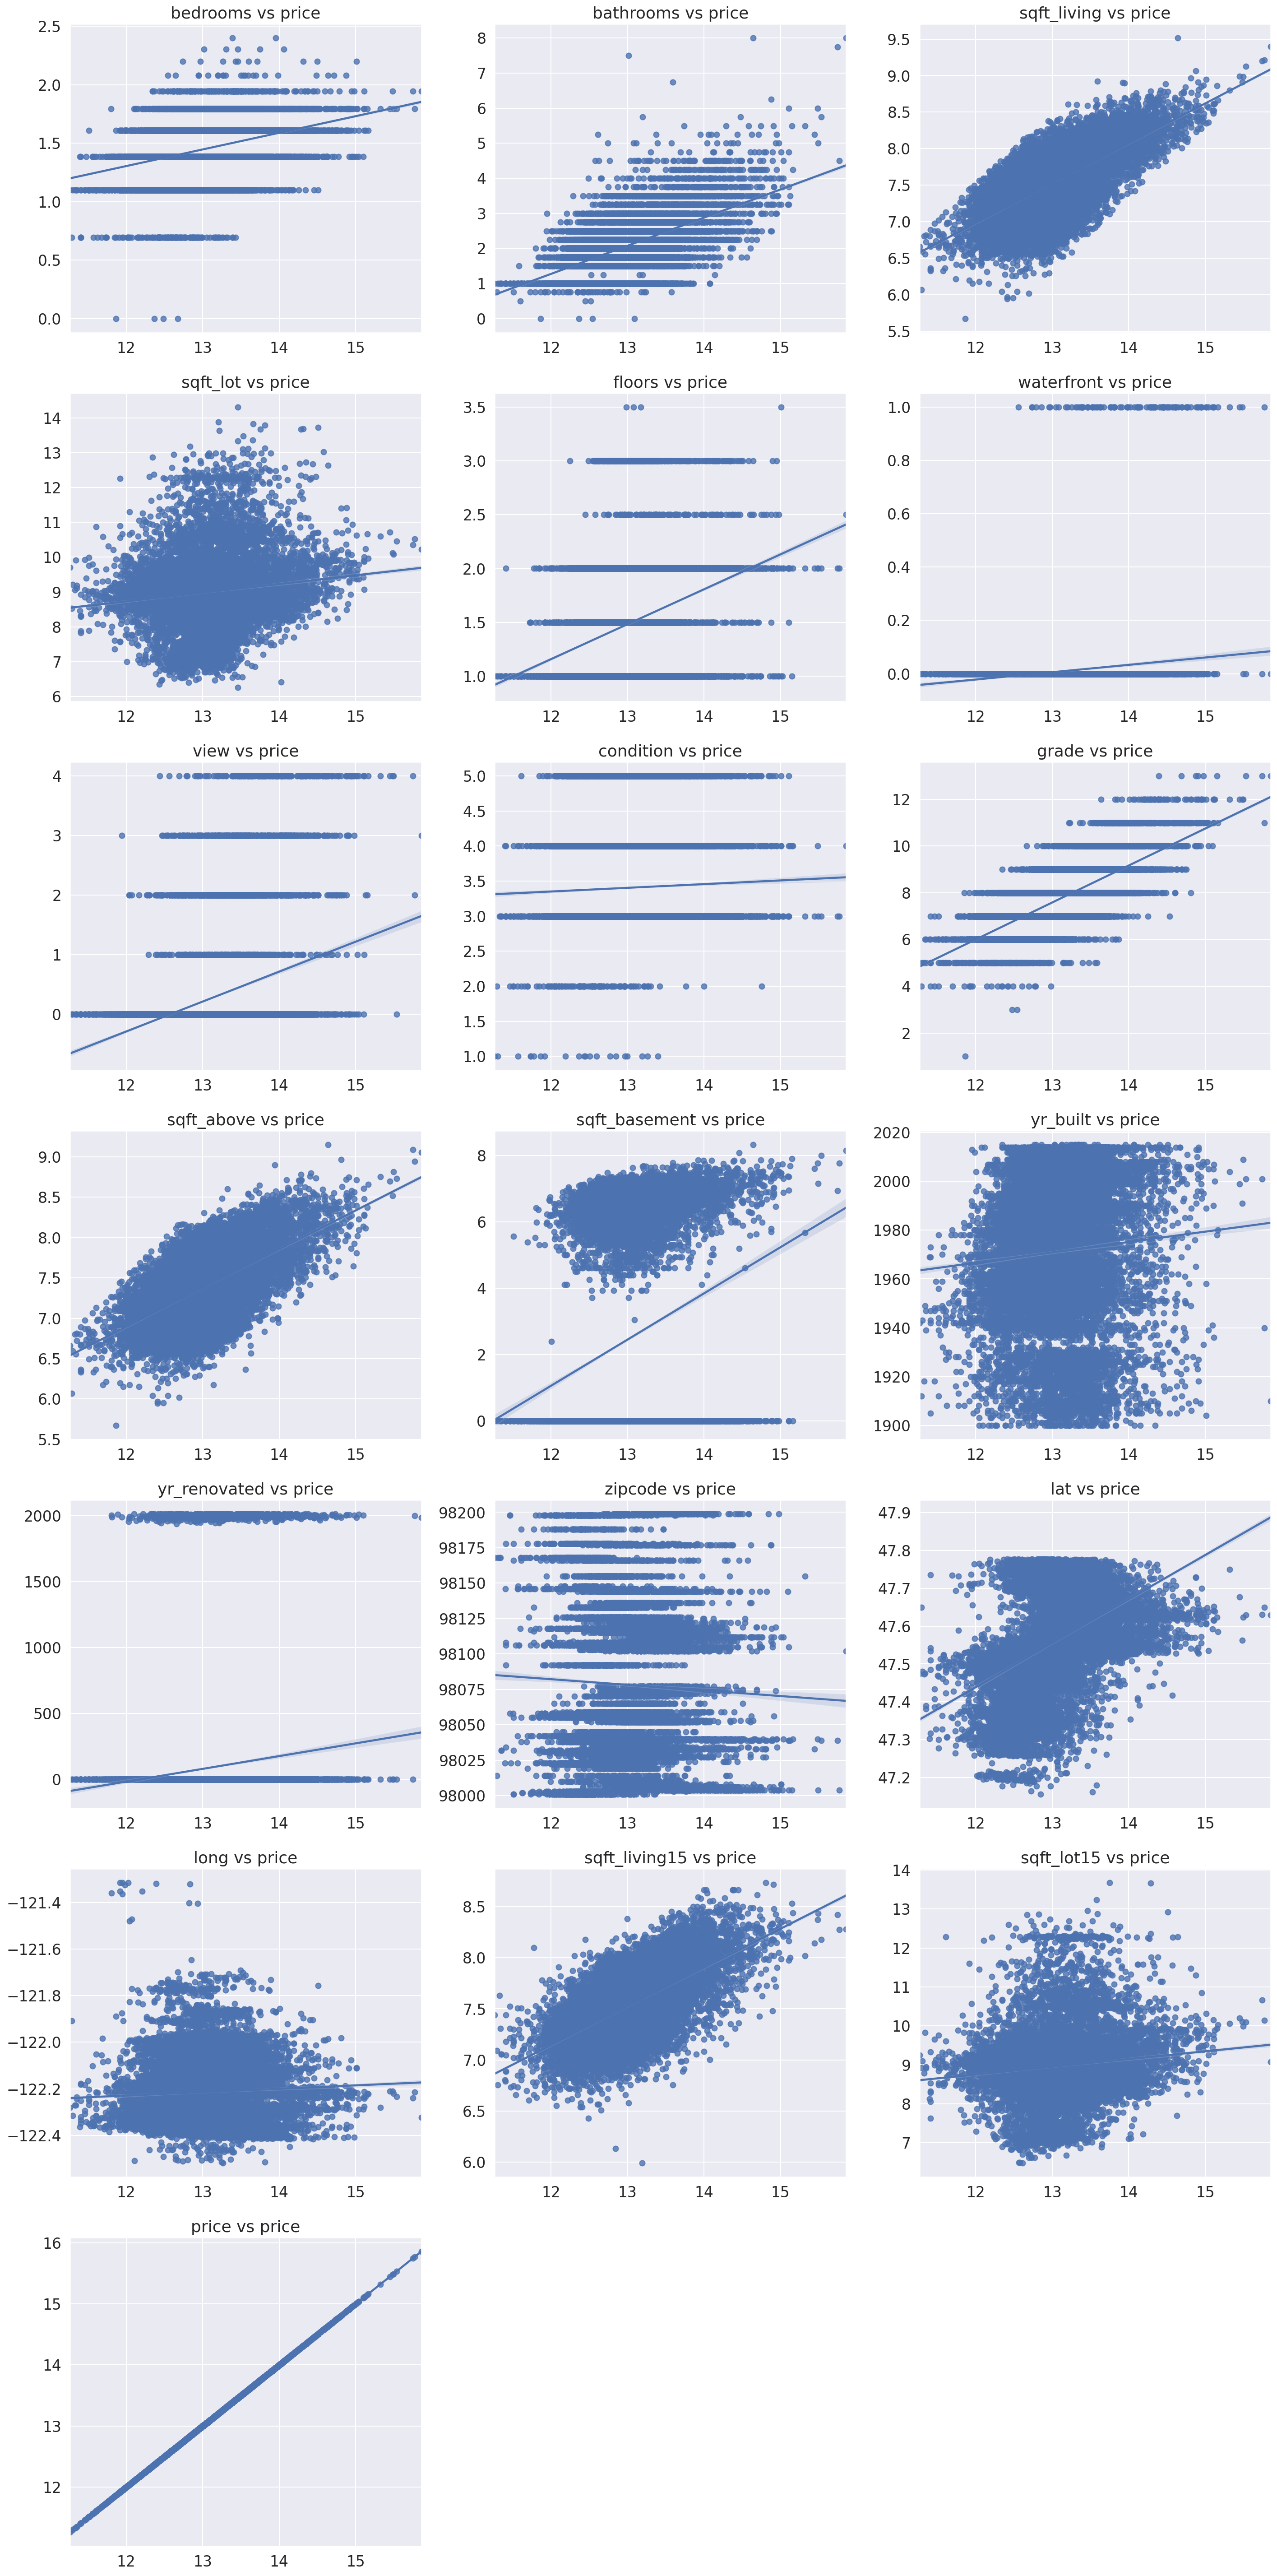

In [25]:
fig = plt.figure(figsize=(20,40))
rows = 7
cols = 3

for idx, col in enumerate(tmp_data.columns):
    ax = fig.add_subplot(rows, cols, idx+1)
    x = tmp_data['price'].values
    y = tmp_data[col].values

    ax.set_title(f'{col} vs price')
    sns.regplot(x=x, y=y, scatter_kws={'alpha': 0.8})

plt.tight_layout()
plt.show()

<br>

- **bedrooms, bathrooms, sqft_living, grade, sqft_above, sqft_living15**가 price와 뚜렷한 양의 상관 관계가 있음을 확인할 수 있다.

### 1-5. 이상치 탐지 및 처리

- 위 6가지 feature의 통계값을 조회하여 이상치가 있는지 확인한다.
- boxplot을 그려서 이상치가 있는지 시각적으로 확인한다.
- bedrooms, bathrooms, grade의 경우, feature 특성상 일부 동떨어진 데이터들을 이상치라고 보기 어렵다고 판단해서 추가로 처리하지 않았다.

In [26]:
key_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15']

box_data = train_data.copy()

# key_cols에 해당하는 column만 남기고 drop
for col in box_data.columns:
    if col not in key_cols:
        box_data.drop(col, axis=1, inplace=True)
        
box_data.head()

bedrooms  bathrooms  sqft_living  grade  sqft_above  sqft_living15
0  1.386294       1.00     7.074117      7    7.074117       7.201171
1  1.098612       1.00     6.647688      6    6.647688       7.908755
2  1.386294       2.00     7.427144      8    7.427144       7.496097
3  1.386294       2.25     7.447751      7    7.447751       7.713785
4  1.386294       1.50     6.966967      7    6.966967       7.409136

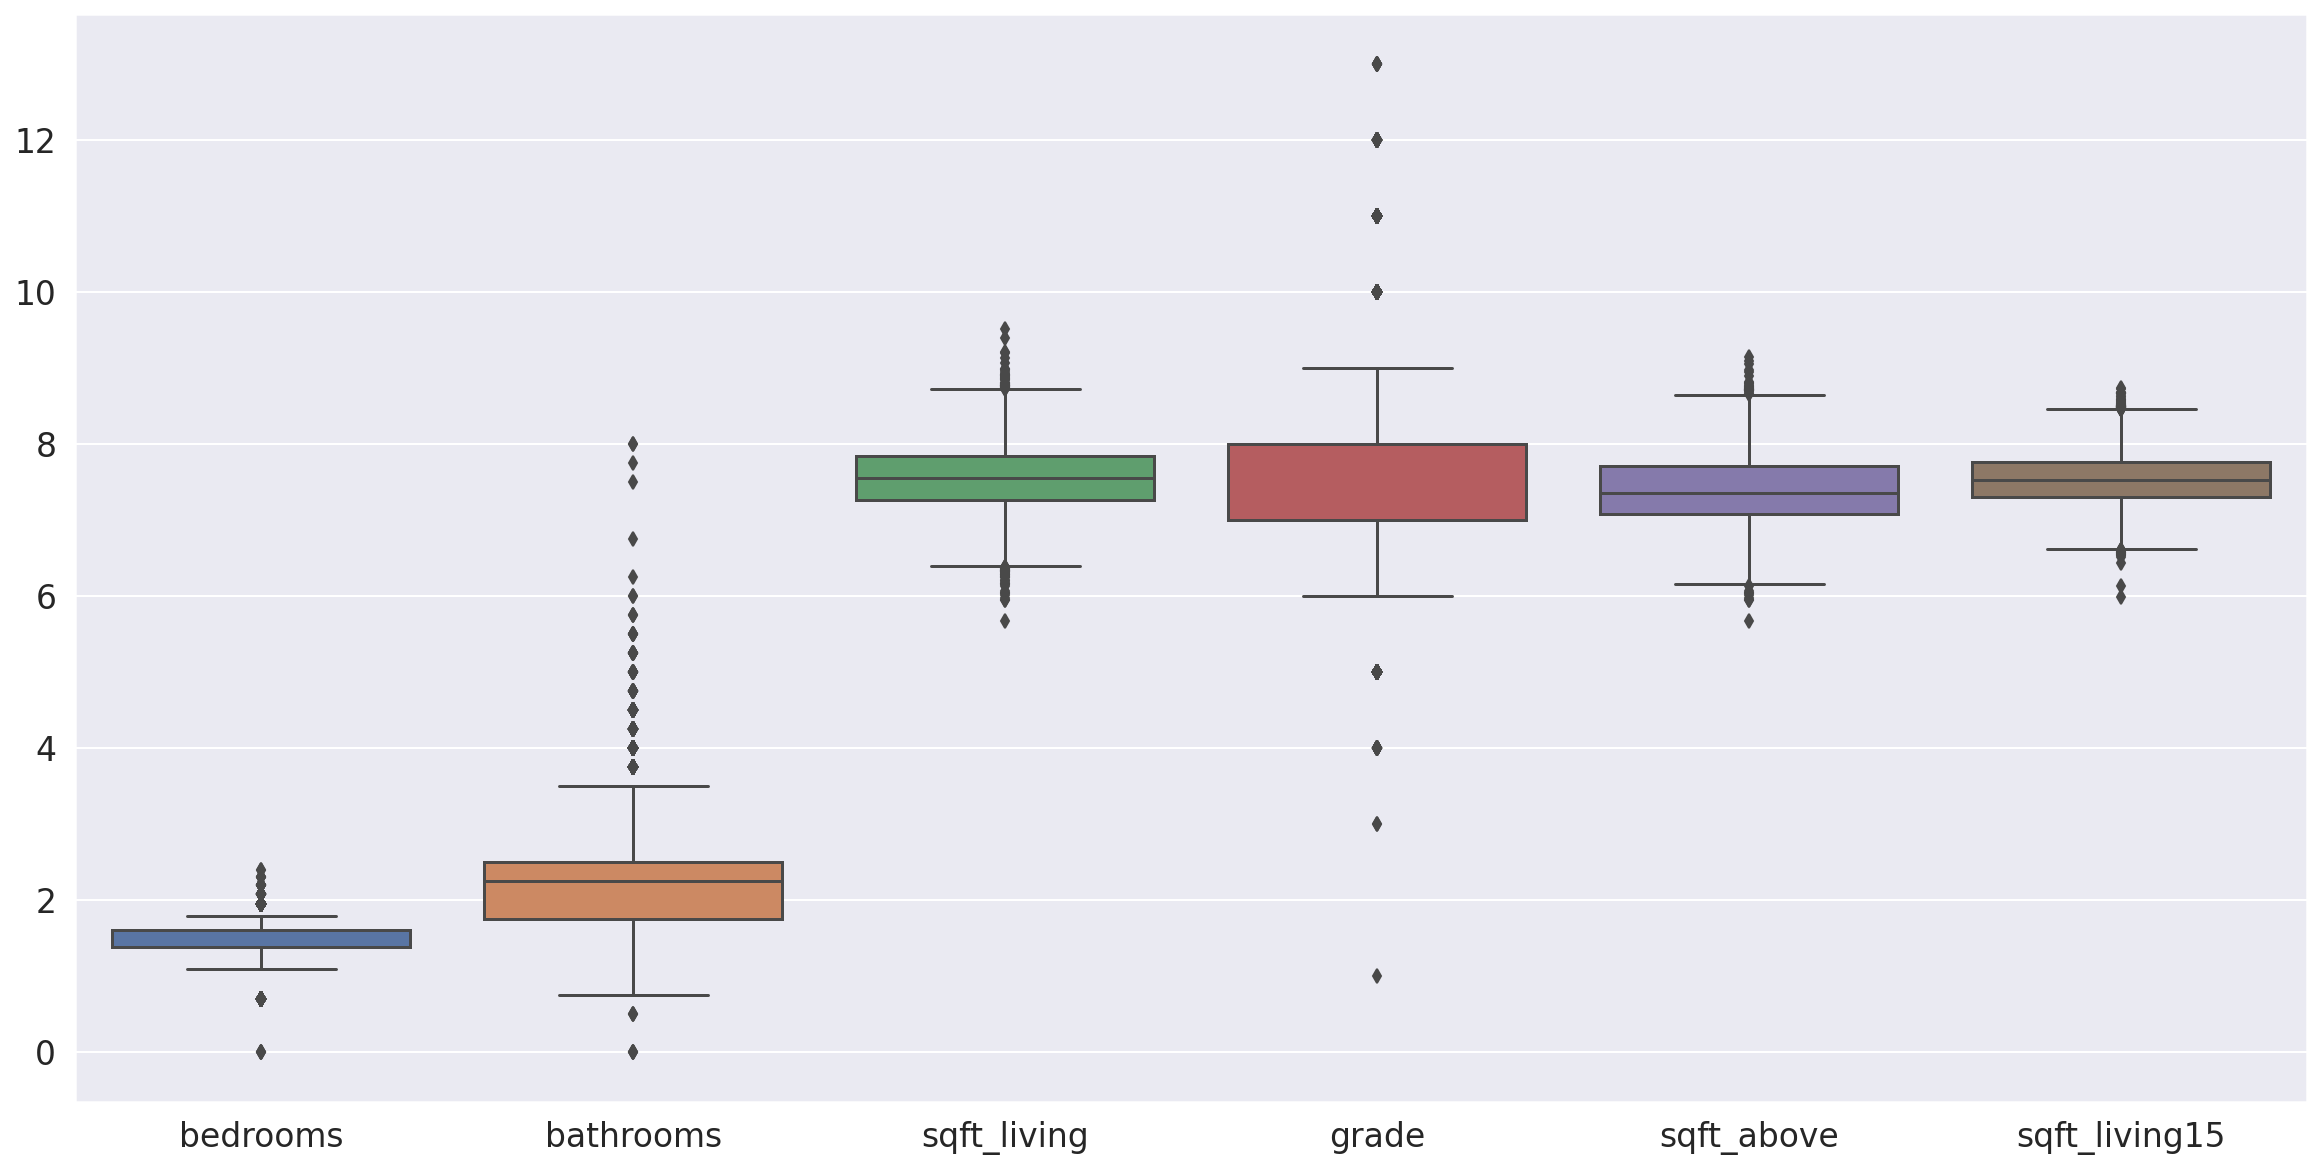

In [27]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(data=box_data)

plt.show()

In [28]:
box_data.describe()

bedrooms     bathrooms   sqft_living         grade    sqft_above  \
count  15035.000000  15035.000000  15035.000000  15035.000000  15035.000000   
mean       1.452912      2.115065      7.552362      7.660725      7.398105   
std        0.210784      0.767519      0.425656      1.179803      0.429372   
min        0.000000      0.000000      5.673323      1.000000      5.673323   
25%        1.386294      1.750000      7.266129      7.000000      7.082549   
50%        1.386294      2.250000      7.555382      7.000000      7.359468   
75%        1.609438      2.500000      7.848153      8.000000      7.710205   
max        2.397895      8.000000      9.513477     13.000000      9.149634   

       sqft_living15  
count   15035.000000  
mean        7.542604  
std         0.328778  
min         5.991465  
25%         7.307202  
50%         7.523481  
75%         7.766841  
max         8.734077

### 1-6. year, month feature 추가

- 주어진 데이터는 2014년 5월부터 2015년 5월까지 집을 구매한 날짜를 포함한다.
- 집을 구매한 시기는 가격과 직결되는 매우 중요한 feature라고 판단하여, year와 month feature를 추가했다.

In [29]:
train_data['year'] = train_data['date'].apply(lambda x: str(x)[:4]).astype(int)
train_data['month'] = train_data['date'].apply(lambda x: str(x)[4:]).astype(int)

train_data.drop('date', axis=1, inplace=True)

train_data.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0  1.386294       1.00     7.074117  8.639588     1.0           0     0   
1  1.098612       1.00     6.647688  9.210440     1.0           0     0   
2  1.386294       2.00     7.427144  8.997271     1.0           0     0   
3  1.386294       2.25     7.447751  8.827615     2.0           0     0   
4  1.386294       1.50     6.966967  9.181118     1.0           0     0   

   condition  grade  sqft_above  ...  yr_built  yr_renovated  zipcode  \
0          3      7    7.074117  ...      1955             0    98178   
1          3      6    6.647688  ...      1933             0    98028   
2          3      8    7.427144  ...      1987             0    98074   
3          3      7    7.447751  ...      1995             0    98003   
4          3      7    6.966967  ...      1963             0    98198   

       lat     long  sqft_living15  sqft_lot15      price  year  month  
0  47.5112 -122.257       7.201171    8.639588  12.309987  2014     10  
1  47.7379 -122.233       7.908755    8.995041  12.100718  2015      2  
2  47.6168 -122.045       7.496097    8.923191  13.142168  2015      2  
3  47.3097 -122.327       7.713785    8.827615  12.458779  2014      6  
4  47.4095 -122.315       7.409136    9.181118  12.583999  2015      1  

[5 rows x 21 columns]

In [30]:
test_data['year'] = test_data['date'].apply(lambda x: str(x)[:4]).astype(int)
test_data['month'] = test_data['date'].apply(lambda x: str(x)[4:]).astype(int)

test_data.drop('date', axis=1, inplace=True)

test_data.head()

bedrooms  bathrooms  sqft_living   sqft_lot  floors  waterfront  view  \
0  1.386294       2.25     7.852050   8.887791     2.0           0     0   
1  1.609438       3.00     7.581210   8.517393     1.0           0     0   
2  1.609438       4.50     8.598036  11.532051     1.0           0     0   
3  1.386294       1.00     7.484930   8.918784     1.0           0     0   
4  1.386294       2.50     7.544861   8.788898     2.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7    7.682943       5.993961      1951          1991   
1          5      7    6.957497       6.814543      1965             0   
2          3     11    8.266421       7.333676      2001             0   
3          3      7    6.957497       6.594413      1960             0   
4          3      7    7.544861       0.000000      2003             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  year  month  
0    98125  47.7210 -122.319       7.433075    8.941153  2014     12  
1    98136  47.5208 -122.393       7.215975    8.517393  2014     12  
2    98053  47.6561 -122.005       8.468213   11.532051  2014      5  
3    98146  47.5123 -122.337       7.484930    9.001346  2015      4  
4    98038  47.3684 -122.031       7.779467    8.932080  2015      3

<br>

- 마지막으로 다시 label 데이터를 삭제하고, train과 test 데이터셋 분리해 저장한다.

In [31]:
# 데이터셋에서 label 데이터 drop
train_data.drop('price', axis=1, inplace=True)

train_data.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0  1.386294       1.00     7.074117  8.639588     1.0           0     0   
1  1.098612       1.00     6.647688  9.210440     1.0           0     0   
2  1.386294       2.00     7.427144  8.997271     1.0           0     0   
3  1.386294       2.25     7.447751  8.827615     2.0           0     0   
4  1.386294       1.50     6.966967  9.181118     1.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7    7.074117            0.0      1955             0   
1          3      6    6.647688            0.0      1933             0   
2          3      8    7.427144            0.0      1987             0   
3          3      7    7.447751            0.0      1995             0   
4          3      7    6.966967            0.0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  year  month  
0    98178  47.5112 -122.257       7.201171    8.639588  2014     10  
1    98028  47.7379 -122.233       7.908755    8.995041  2015      2  
2    98074  47.6168 -122.045       7.496097    8.923191  2015      2  
3    98003  47.3097 -122.327       7.713785    8.827615  2014      6  
4    98198  47.4095 -122.315       7.409136    9.181118  2015      1

In [39]:
x_train = train_data.copy()
x_test = test_data.copy()

print(x_train.shape)
print(x_test.shape)

(15035, 20)
(6468, 20)


In [40]:
x_train.head()

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
0  1.386294       1.00     7.074117  8.639588     1.0           0     0   
1  1.098612       1.00     6.647688  9.210440     1.0           0     0   
2  1.386294       2.00     7.427144  8.997271     1.0           0     0   
3  1.386294       2.25     7.447751  8.827615     2.0           0     0   
4  1.386294       1.50     6.966967  9.181118     1.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7    7.074117            0.0      1955             0   
1          3      6    6.647688            0.0      1933             0   
2          3      8    7.427144            0.0      1987             0   
3          3      7    7.447751            0.0      1995             0   
4          3      7    6.966967            0.0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  year  month  
0    98178  47.5112 -122.257       7.201171    8.639588  2014     10  
1    98028  47.7379 -122.233       7.908755    8.995041  2015      2  
2    98074  47.6168 -122.045       7.496097    8.923191  2015      2  
3    98003  47.3097 -122.327       7.713785    8.827615  2014      6  
4    98198  47.4095 -122.315       7.409136    9.181118  2015      1

In [41]:
x_test.head()

bedrooms  bathrooms  sqft_living   sqft_lot  floors  waterfront  view  \
0  1.386294       2.25     7.852050   8.887791     2.0           0     0   
1  1.609438       3.00     7.581210   8.517393     1.0           0     0   
2  1.609438       4.50     8.598036  11.532051     1.0           0     0   
3  1.386294       1.00     7.484930   8.918784     1.0           0     0   
4  1.386294       2.50     7.544861   8.788898     2.0           0     0   

   condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3      7    7.682943       5.993961      1951          1991   
1          5      7    6.957497       6.814543      1965             0   
2          3     11    8.266421       7.333676      2001             0   
3          3      7    6.957497       6.594413      1960             0   
4          3      7    7.544861       0.000000      2003             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  year  month  
0    98125  47.7210 -122.319       7.433075    8.941153  2014     12  
1    98136  47.5208 -122.393       7.215975    8.517393  2014     12  
2    98053  47.6561 -122.005       8.468213   11.532051  2014      5  
3    98146  47.5123 -122.337       7.484930    9.001346  2015      4  
4    98038  47.3684 -122.031       7.779467    8.932080  2015      3

In [35]:
y.shape

(15035,)

<hr>

<br>

## 2. 모델 설계 및 학습

- gboost, xgboost, lightgbm, randomforest의 네 가지 모델을 블렌딩하였다.
- cross_val_score를 이용해 네 모델의 성능을 평가한다.
- 네 모델을 학습시킨 후 예측 결과값의 평균값을 도출한다.

In [36]:
# 동일한 성능 확인을 위해 random_state 고정
random_state = 22

# 아래 네 가지 모델을 이용
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb.XGBRegressor(random_state=random_state)
lightgbm = lgb.LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name': 'LightGBM'}, {'model': rdforest, 'name': 'RandomForest'}]

In [37]:
# 교차 검증으로 모델 성능 평가
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=random_state).get_n_splits(x_train.values)
    
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x_train.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score: {CV_score:.4f}")

In [42]:
get_cv_score(models)

Model: GradientBoosting, CV score: 0.8792
Model: XGBoost, CV score: 0.8972
Model: LightGBM, CV score: 0.9023
Model: RandomForest, CV score: 0.8851


In [43]:
# 모델들의 평균 예측값을 구하기
def AveragingBlending(models, x_train, y, x_test):
    for m in models:
        m['model'].fit(x_train.values, y)
        
    predictions = np.column_stack([m['model'].predict(x_test.values) for m in models])
    
    return np.mean(predictions, axis=1)

In [44]:
y_pred = AveragingBlending(models, x_train, y, x_test)

In [45]:
# 원래 스케일로 되돌리기
final_pred = np.expm1(y_pred)

final_pred 

array([ 514876.62139136,  452563.58255565, 1324958.83159607, ...,
        460037.2126138 ,  330605.63900482,  440482.81100463])

<br>

- submission.csv 생성 및 제출

In [46]:
data_dir = os.getenv('HOME')+'/aiffel/aiffel_projects/exploration/E6_kaggle_kakr_housing/data'

# sample_submission 형태 살펴보기
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [47]:
result = pd.DataFrame({'id': sub_id, 'price': final_pred})

result.head()

id         price
0  15035  5.148766e+05
1  15036  4.525636e+05
2  15037  1.324959e+06
3  15038  3.033276e+05
4  15039  3.212831e+05

In [ ]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

## 3. 평가 및 회고

- 시간을 많이 투자해서 다양한 전처리와 feature extract를 하지 못한 점이 아쉽다.
- 더 다양한 모델과 평가 방식을 적용해보지 못한 점이 아쉽다.
- 최종 private score 117822로 110000 이하를 달성하지 못해 아쉽다.
- 그래도 데이터 분석에 필요한 전반적인 과정을 경험할 수 있는 좋은 기회였다.

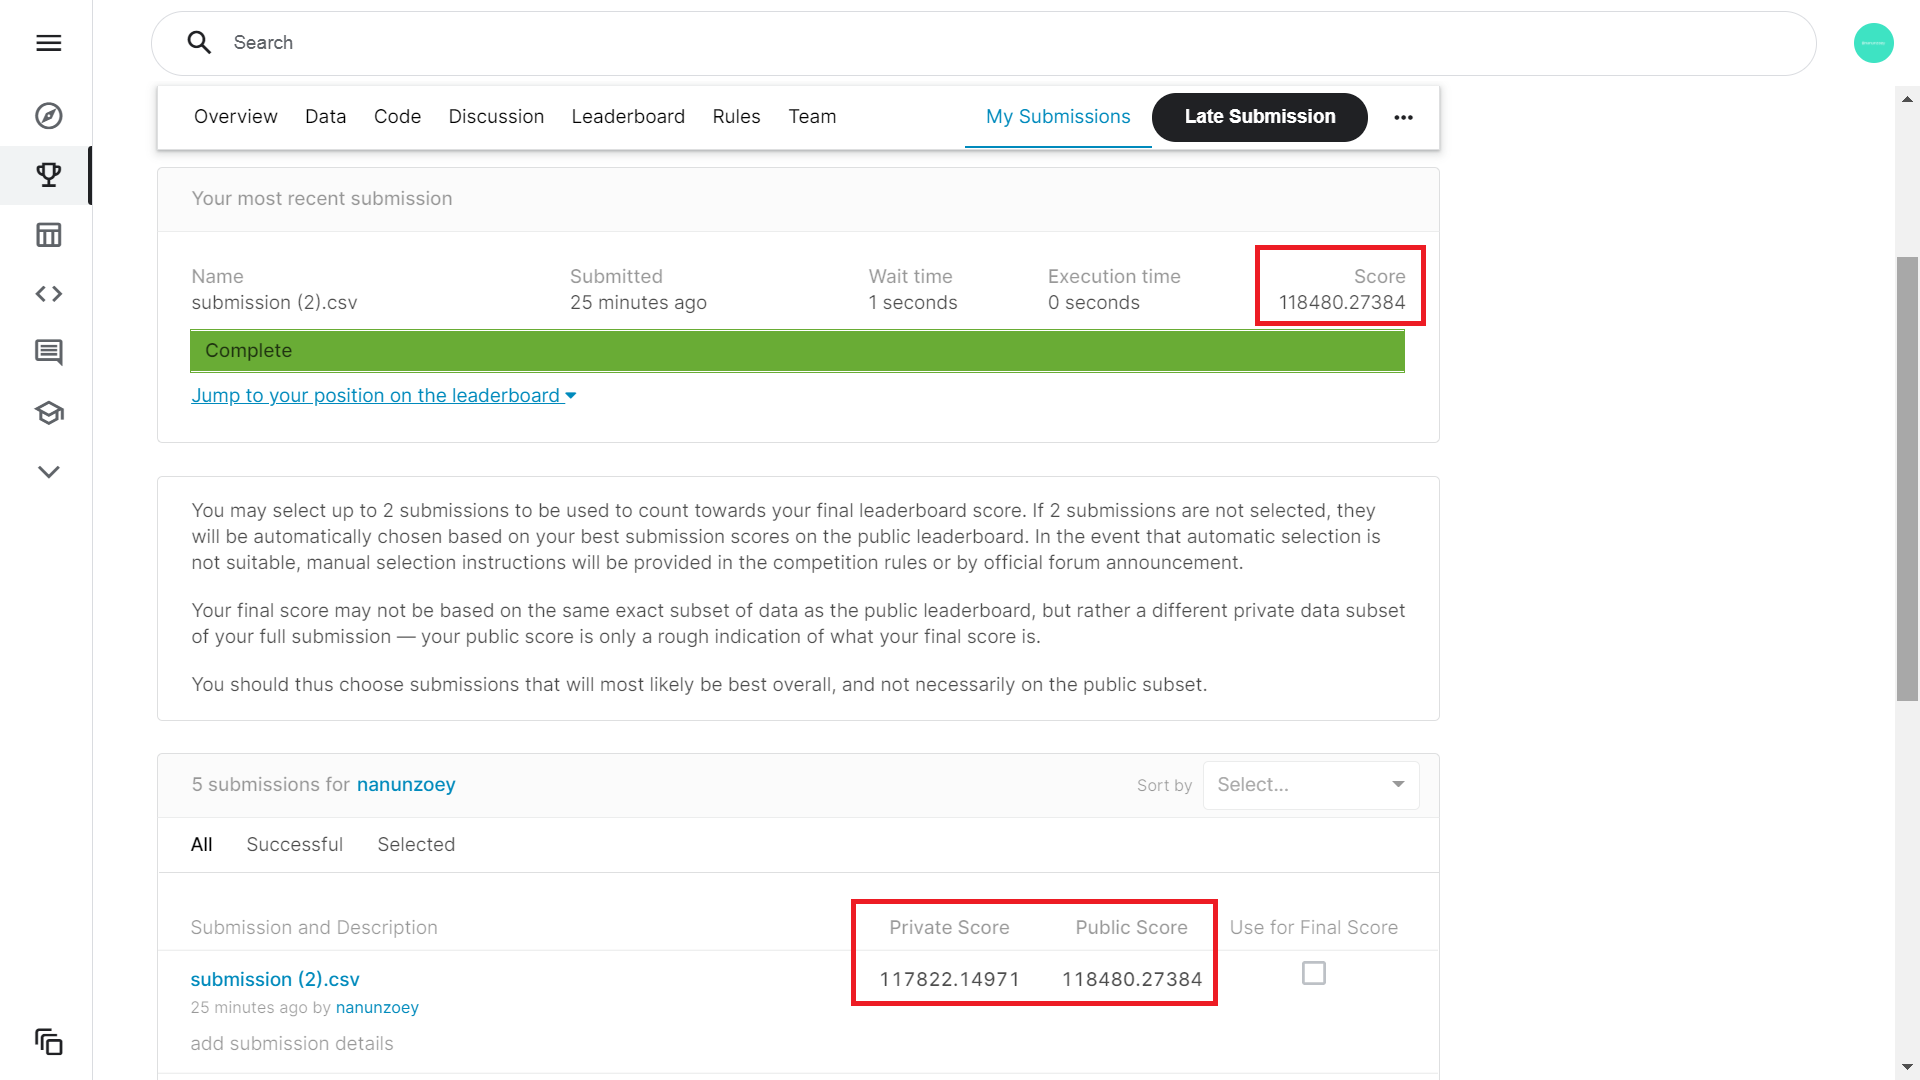